In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
from collections import Counter
import scipy
from scipy.stats import entropy
from fastdtw import fastdtw
import config

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from P_UTILS import compute_var

c:\users\camil\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


you are on windows, so pycocotools can not be installed


In [3]:
PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from UTILS.utils import avg_diff_linbr, chi2_distance

TODO: ATTENTION au jour sans record!!!
    li_date2remove = ['2019-07-09', '2019-07-10', '2019-07-16', '2019-07-17', '2019-07-23', '2019-07-24', '2019-07-30', 
                  '2019-07-31', '2019-08-06', '2019-08-07', '2019-08-13', '2019-08-14', '2019-08-19', '2019-08-20', 
                  '2019-08-21']

# Define parameters

In [4]:
#choose folder names
path_initial_data = config.path_initial_data
path_extracted_data = config.path_extracted_data

#choose time serie name
ts_name = 'df_time_serie_day' #df_time_serie_day, df_time_serie_night

#list of date to be removed
li_date2remove = config.li_date2remove
li_date2remove = [dt.datetime.strptime(x, '%Y-%m-%d') for x in li_date2remove]
li_date2remove

[datetime.datetime(2019, 7, 9, 0, 0),
 datetime.datetime(2019, 7, 10, 0, 0),
 datetime.datetime(2019, 7, 16, 0, 0),
 datetime.datetime(2019, 7, 17, 0, 0),
 datetime.datetime(2019, 7, 23, 0, 0),
 datetime.datetime(2019, 7, 24, 0, 0),
 datetime.datetime(2019, 7, 30, 0, 0),
 datetime.datetime(2019, 7, 31, 0, 0),
 datetime.datetime(2019, 8, 6, 0, 0),
 datetime.datetime(2019, 8, 7, 0, 0),
 datetime.datetime(2019, 8, 13, 0, 0),
 datetime.datetime(2019, 8, 14, 0, 0),
 datetime.datetime(2019, 8, 19, 0, 0),
 datetime.datetime(2019, 8, 20, 0, 0),
 datetime.datetime(2019, 8, 21, 0, 0)]

# Download initial data

In [5]:
#choose the time series dataframe you want
df = pd.read_csv(os.path.join(path_extracted_data,ts_name+'.csv'), sep=';',index_col=0)
df['day'] = pd.to_datetime(df['day'], format="%Y.%m.%d")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y.%m.%d %H:%M:%S") 
print(df.shape)
print(min(df['Timestamp']), max(df['Timestamp']))
df.head(3)

(525000, 104)


,Timestamp,hen_10A,hen_10B,hen_10C,hen_10F,hen_10H,hen_10L,hen_10M,hen_10S,hen_10V,...,hen_9F,hen_9H,hen_9L,hen_9M,hen_9S,hen_9V,hen_9X,day,hour,date_toberemoved
10729,2019-07-08 07:05:55,Interzone_R,Einstreu 6-10,Rampe 6-10,Box20,Box20,Box20,Einstreu 6-10,Einstreu 6-10,Box19,...,Einstreu 6-10,Einstreu 6-10,Interzone_ER,Interzone_ER,Einstreu 6-10,Interzone_ER,Einstreu 6-10,2019-07-08,7,False
10730,2019-07-08 07:05:58,Interzone_R,Einstreu 6-10,Rampe 6-10,Box20,Box20,Box20,Einstreu 6-10,Einstreu 6-10,Box19,...,Einstreu 6-10,Einstreu 6-10,Interzone_ER,Interzone_ER,Einstreu 6-10,Interzone_ER,Einstreu 6-10,2019-07-08,7,False
10731,2019-07-08 07:06:01,Interzone_R,Einstreu 6-10,Rampe 6-10,Box20,Box20,Box20,Einstreu 6-10,Einstreu 6-10,Box19,...,Einstreu 6-10,Einstreu 6-10,Interzone_ER,Interzone_ER,Einstreu 6-10,Interzone_ER,Einstreu 6-10,2019-07-08,7,False


# Preprocessing

### add correct 'day' variable (i.e. consecutive time slot for night time series)

In [7]:
#note that minuit is: 0, and its date should be as 1,2 (day-1, day)
if ts_name == 'df_time_serie_night':
    df['daily_level'] = df.apply(lambda x: str(x['day'])[0:-9]+'_'+str(x['day']+dt.timedelta(days=1))[8:10] if x['hour']>=17 else \
                               str(x['day']-dt.timedelta(days=1))[0:-9]+'_'+str(x['day'])[8:10], axis=1)
df.head(3)

,Timestamp,hen_10A,hen_10B,hen_10C,hen_10F,hen_10H,hen_10L,hen_10M,hen_10S,hen_10V,...,hen_9F,hen_9H,hen_9L,hen_9M,hen_9S,hen_9V,hen_9X,day,hour,date_toberemoved
10729,2019-07-08 07:05:55,Interzone_R,Einstreu 6-10,Rampe 6-10,Box20,Box20,Box20,Einstreu 6-10,Einstreu 6-10,Box19,...,Einstreu 6-10,Einstreu 6-10,Interzone_ER,Interzone_ER,Einstreu 6-10,Interzone_ER,Einstreu 6-10,2019-07-08,7,False
10730,2019-07-08 07:05:58,Interzone_R,Einstreu 6-10,Rampe 6-10,Box20,Box20,Box20,Einstreu 6-10,Einstreu 6-10,Box19,...,Einstreu 6-10,Einstreu 6-10,Interzone_ER,Interzone_ER,Einstreu 6-10,Interzone_ER,Einstreu 6-10,2019-07-08,7,False
10731,2019-07-08 07:06:01,Interzone_R,Einstreu 6-10,Rampe 6-10,Box20,Box20,Box20,Einstreu 6-10,Einstreu 6-10,Box19,...,Einstreu 6-10,Einstreu 6-10,Interzone_ER,Interzone_ER,Einstreu 6-10,Interzone_ER,Einstreu 6-10,2019-07-08,7,False


In [8]:
df.tail(3)

,Timestamp,hen_10A,hen_10B,hen_10C,hen_10F,hen_10H,hen_10L,hen_10M,hen_10S,hen_10V,...,hen_9F,hen_9H,hen_9L,hen_9M,hen_9S,hen_9V,hen_9X,day,hour,date_toberemoved
1339726,2019-08-23 10:35:46,Interzone_E,Interzone_E,Interzone_E,Interzone_ER,Interzone_E,Interzone_E,Interzone_R,Interzone_E,Interzone_E,...,Interzone_E,Interzone_E,Interzone_E,Interzone_E,Interzone_ER,Interzone_E,Interzone_E,2019-08-23,10,False
1339727,2019-08-23 10:35:49,Interzone_E,Interzone_E,Interzone_E,Interzone_ER,Interzone_E,Interzone_E,Interzone_R,Interzone_E,Interzone_E,...,Interzone_E,Interzone_E,Interzone_E,Interzone_E,Interzone_ER,Interzone_E,Interzone_E,2019-08-23,10,False
1339728,2019-08-23 10:35:52,Interzone_E,Interzone_E,Interzone_E,Interzone_ER,Interzone_E,Interzone_E,Interzone_R,Interzone_E,Interzone_E,...,Interzone_E,Interzone_E,Interzone_E,Interzone_E,Interzone_E,Interzone_E,Interzone_E,2019-08-23,10,False


# Compute variables

In [9]:
df['daily_level'] = df['day'].copy()

The number of hours per "daily_level" period is of:


,verification_daily_total_nbr_hour,daily_level
0,7.598333,{2019-08-23 00:00:00}
1,9.901667,{2019-07-08 00:00:00}
2,14.000000,"{2019-07-11 00:00:00, 2019-08-05 00:00:00, 201..."


(3200, 19)
several max-duration-zone
several max-duration-zone
several max-duration-zone
several max-duration-zone
several max-duration-zone
several max-duration-zone
several max-duration-zone
several max-duration-zone


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

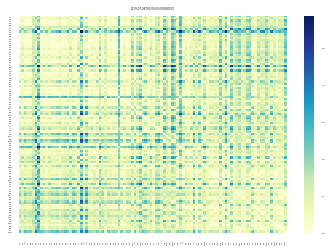

  3%|██▌                                                                                | 1/32 [00:16<08:32, 16.53s/it]

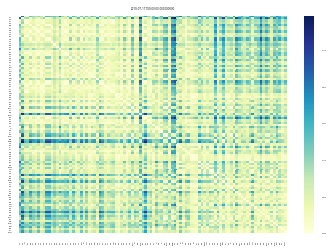

  6%|█████▏                                                                             | 2/32 [00:32<08:14, 16.47s/it]

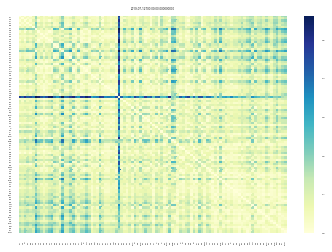

  9%|███████▊                                                                           | 3/32 [00:47<07:42, 15.94s/it]

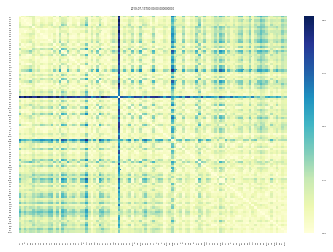

 12%|██████████▍                                                                        | 4/32 [01:03<07:24, 15.88s/it]

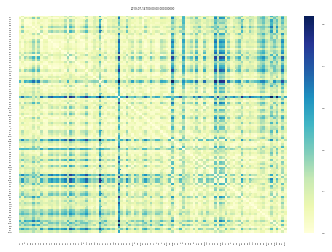

 16%|████████████▉                                                                      | 5/32 [01:18<07:06, 15.81s/it]

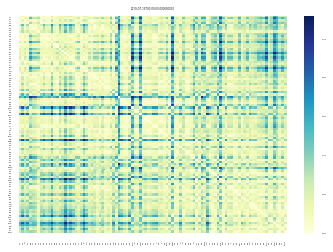

 19%|███████████████▌                                                                   | 6/32 [01:34<06:52, 15.87s/it]

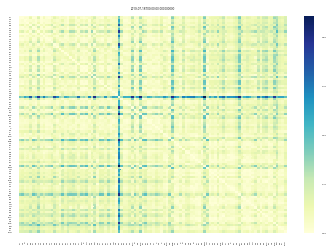

 22%|██████████████████▏                                                                | 7/32 [01:49<06:28, 15.52s/it]

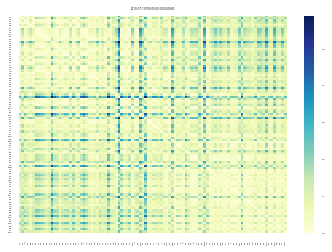

 25%|████████████████████▊                                                              | 8/32 [02:04<06:05, 15.24s/it]

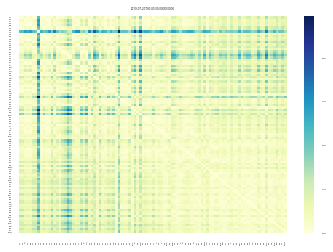

 28%|███████████████████████▎                                                           | 9/32 [02:19<05:48, 15.17s/it]

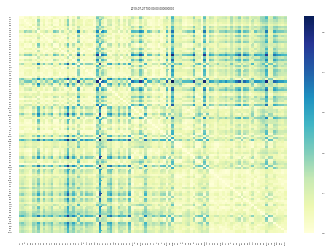

 31%|█████████████████████████▋                                                        | 10/32 [02:34<05:31, 15.07s/it]

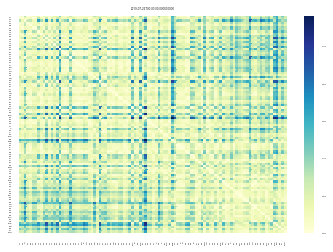

 34%|████████████████████████████▏                                                     | 11/32 [02:48<05:15, 15.02s/it]

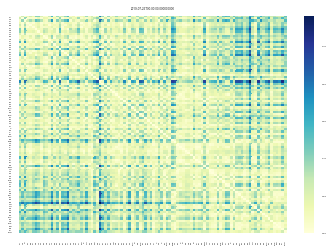

 38%|██████████████████████████████▊                                                   | 12/32 [03:03<04:57, 14.86s/it]

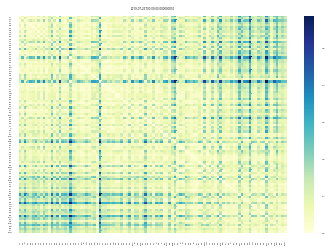

 41%|█████████████████████████████████▎                                                | 13/32 [03:19<04:46, 15.10s/it]

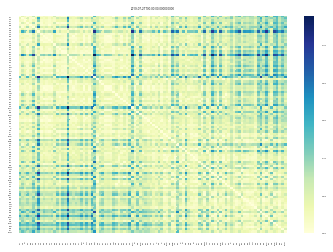

 44%|███████████████████████████████████▉                                              | 14/32 [03:34<04:31, 15.06s/it]

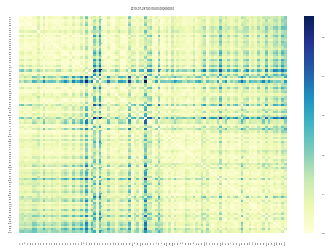

 47%|██████████████████████████████████████▍                                           | 15/32 [03:49<04:18, 15.23s/it]

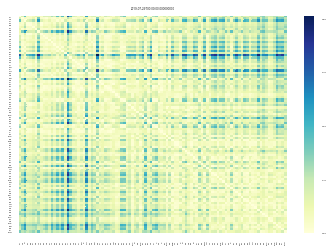

 50%|█████████████████████████████████████████                                         | 16/32 [04:05<04:04, 15.28s/it]

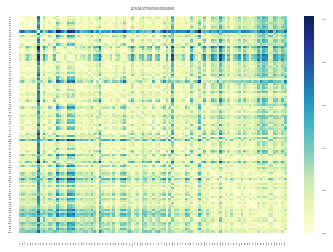

 53%|███████████████████████████████████████████▌                                      | 17/32 [04:20<03:47, 15.17s/it]

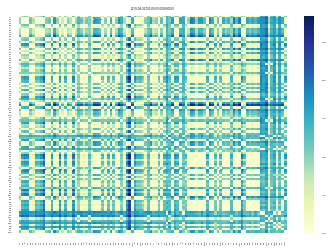

 56%|██████████████████████████████████████████████▏                                   | 18/32 [04:34<03:28, 14.86s/it]

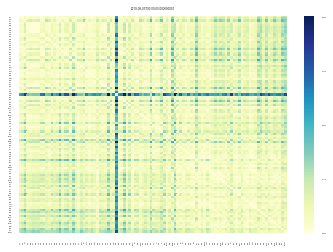

 59%|████████████████████████████████████████████████▋                                 | 19/32 [04:49<03:13, 14.86s/it]

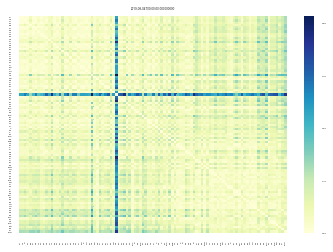

 62%|███████████████████████████████████████████████████▎                              | 20/32 [05:04<03:00, 15.04s/it]

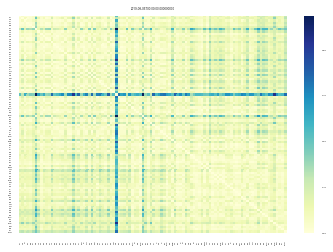

 66%|█████████████████████████████████████████████████████▊                            | 21/32 [05:19<02:43, 14.89s/it]

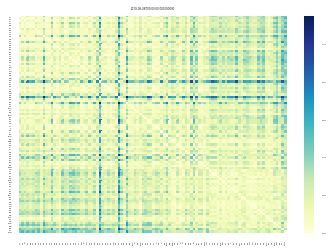

 69%|████████████████████████████████████████████████████████▍                         | 22/32 [05:34<02:30, 15.04s/it]

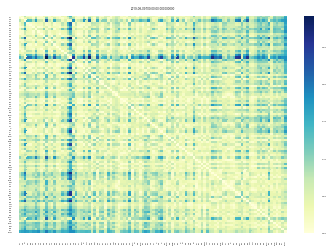

 72%|██████████████████████████████████████████████████████████▉                       | 23/32 [05:49<02:16, 15.16s/it]

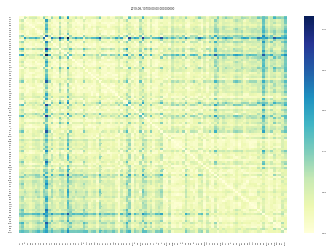

 75%|█████████████████████████████████████████████████████████████▌                    | 24/32 [06:06<02:04, 15.52s/it]

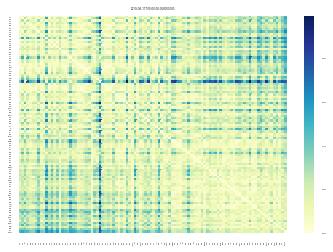

 78%|████████████████████████████████████████████████████████████████                  | 25/32 [06:21<01:48, 15.44s/it]

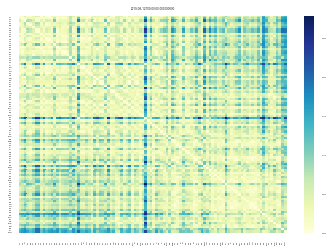

 81%|██████████████████████████████████████████████████████████████████▋               | 26/32 [06:35<01:30, 15.08s/it]

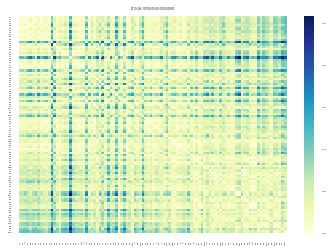

 84%|█████████████████████████████████████████████████████████████████████▏            | 27/32 [06:49<01:13, 14.66s/it]

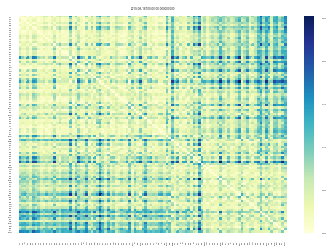

 88%|███████████████████████████████████████████████████████████████████████▊          | 28/32 [07:03<00:58, 14.52s/it]

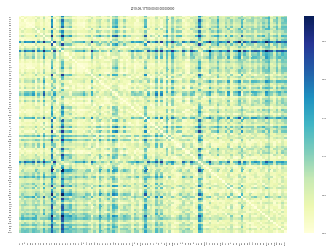

 91%|██████████████████████████████████████████████████████████████████████████▎       | 29/32 [07:19<00:44, 14.85s/it]

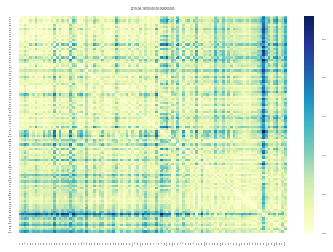

 94%|████████████████████████████████████████████████████████████████████████████▉     | 30/32 [07:35<00:30, 15.16s/it]

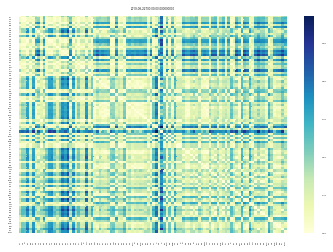

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [07:50<00:15, 15.13s/it]

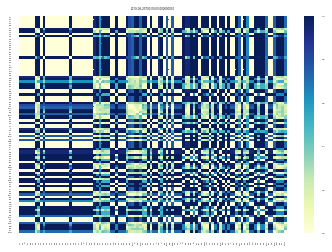

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [08:05<00:00, 15.28s/it]


(3200, 60)


,HenID,daily_level,duration_BoxA,duration_BoxB,duration_Einstreu,duration_Interzone_B,duration_Interzone_BB,duration_Interzone_BBE,duration_Interzone_BBER,duration_Interzone_BBR,...,nbr_bouts_Interzone_BBE,nbr_bouts_Einstreu,nbr_bouts_Interzone_E,nbr_bouts_Interzone_BER,nbr_bouts_Interzone_R,nbr_bouts_Interzone_BB,nbr_bouts_BoxB,nbr_bouts_Interzone_ER,nbr_bouts_Interzone_BBER,nbr_bouts_Interzone_BBR
0,hen_10A,2019-07-08,801.0,1020.0,25245.0,6.0,12.0,0.0,0.0,0.0,...,0,43,1,0,2,1,24,14,0,0
1,hen_10A,2019-07-11,99.0,0.0,38223.0,0.0,0.0,0.0,0.0,0.0,...,0,44,0,0,0,0,0,11,0,0
2,hen_10A,2019-07-12,303.0,117.0,35562.0,0.0,0.0,0.0,0.0,0.0,...,0,31,0,0,0,0,4,6,0,0


In [10]:
df_daily = compute_var(df, config)
print(df_daily.shape)
df_daily.head(3)

In [11]:
sys.exit()

SystemExit: 

# Verification & correction

#### to much bouts

In [ ]:
df_daily[(df_daily['nbr_bouts_BoxB']>100)&(df_daily['day']=='2019-07-11')]

In [ ]:
df_daily.columns

#### to few bouts

In [ ]:
#when number of transition per day per hen is <=2
df_test = df_daily[df_daily['Total_number_transition']<2]
if df_test.shape[0]>0:
    print('Some hen has strictly less than 2 transition per day, what should I do with it?')
    sys.exit()

### Save

In [ ]:
df_daily.groupby(['verification_daily_total_duration','day'])['Total_number_zone'].count().reset_index()

In [ ]:
df_daily.drop(['verification_daily_total_duration'],inplace=True,axis=1)
df_daily.to_csv(os.path.join(path_extracted_data,ts_name+'_variables.csv'), sep=';')

In [ ]:
df_daily.columns

# Final cleaning

In [ ]:
#remove days of chick without any transition
#TODO WHEN DATA

# Visual

In [ ]:
df_daily.head(3)[['HenID','day','dico_zone_duration']]

In [ ]:
#if we want to update list of dictionary this way:
def concat_dico(li_d):
    d = {}
    for d_ in li_d:
        for k,v in d_.items():
            if k not in d:
                d[k] = []
            d[k].extend(v)
    return d
#small example
concat_dico(li)
li = [{'1':[2],'11':[5656,23,1]},{'1':[1,2,3]},{'10':[8],'11':[22,872]}]

In [ ]:
df_bouts_duration = df_daily.groupby('HenID')['dico_zone_duration'].agg(lambda x: concat_dico(list(x))).reset_index()
df_bouts_duration.head(3)

In [ ]:
df_bouts_duration = pd.concat([df_bouts_duration.drop(['dico_zone_duration'], axis=1), 
           df_bouts_duration['dico_zone_duration'].apply(pd.Series)], axis=1)
df_bouts_duration = df_bouts_duration[df_bouts_duration['HenID']!='hen_15C3']
df_bouts_duration.fillna(' ',inplace=True)
df_bouts_duration

In [ ]:
#dico_c_ml = {'BoxA':200, 'BoxB':200, 'Einstreu':3000, 'Interzone':3000, 'Rampe':1500}
for c in ['BoxA', 'BoxB', 'Einstreu', 'Interzone', 'Rampe']:
    
    #one line per hen, but no need to differenciate between henID at least for now
    for row in df_bouts_duration[c]:
        if len(row)>5:
            num_bins = 50000
            counts, bin_edges = np.histogram(row, bins=num_bins, normed=False)
            cdf = np.cumsum(counts)
            plt.plot(bin_edges[1:], cdf)
            plt.axvline(x=3, linewidth=1, color='k') #10,20,30,60
            plt.axvline(x=10, linewidth=1, color='k') 
            plt.axvline(x=20, linewidth=1, color='k') 
            plt.axvline(x=30, linewidth=1, color='k') 
            plt.axvline(x=60, linewidth=1, color='k') 
    plt.xlim(0, 120) #dico_c_ml[c]
    plt.title(c+' one line per hen')
    plt.xlabel('duration in a zone (sec)')
    plt.ylabel('number of bouts')
    plt.savefig(os.path.join(path_extracted_data,c+' one line per hen.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()
    
    #one line including all hen
    l = [i for r in df_bouts_duration[c] for i in r if len(r)>5]
    counts, bin_edges = np.histogram(l, bins=num_bins, normed=False)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf)
    plt.axvline(x=3, linewidth=1, color='k') #10,20,30,60
    plt.axvline(x=10, linewidth=1, color='k') 
    plt.axvline(x=20, linewidth=1, color='k') 
    plt.axvline(x=30, linewidth=1, color='k') 
    plt.axvline(x=60, linewidth=1, color='k') 
    plt.xlim(0, 65)
    plt.ylim(0,)
    plt.title(c+' considering all hen')
    plt.xlabel('duration in a zone (sec)')
    plt.ylabel('number of bouts')
    plt.savefig(os.path.join(path_extracted_data,c+' considering all hen.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()